In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json


In [2]:
# Load peptide evolution data
peptide_data = pd.read_csv("../data/peptide_evolution.csv")

# Load membrane thickness history
with open("../data/membrane_thickness.json", "r") as f:
    membrane_data = json.load(f)

# Extract membrane thickness history
membrane_thickness_history = membrane_data["History"]

# Display first few rows of peptide data
peptide_data.head()


,Cycle,Peptide_Count,Membrane_Thickness
0,1,100,3.00
1,2,95,3.05
2,3,88,3.10
3,4,79,3.12
4,5,72,3.18


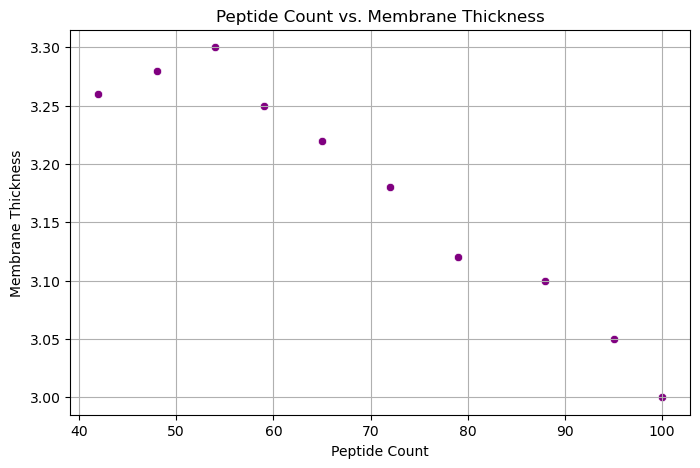

In [4]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="Peptide_Count", y="Membrane_Thickness", data=peptide_data, color="purple")
plt.xlabel("Peptide Count")
plt.ylabel("Membrane Thickness")
plt.title("Peptide Count vs. Membrane Thickness")
plt.grid(True)
plt.show()


In [6]:
import os
import numpy as np
import pandas as pd
import json
import subprocess  # To call D-Flow peptide generator

class DFlowPeptideMembraneSim:
    def __init__(self, num_peptides=200, sequence_length=20, mutation_rate=0.05, max_cycles=1000):
        self.num_peptides = num_peptides
        self.sequence_length = sequence_length
        self.mutation_rate = mutation_rate
        self.max_cycles = max_cycles
        self.peptides = self.generate_peptides()
        self.membrane_thickness = np.random.uniform(2.5, 3.5)
        self.peptide_evolution_log = []

    def generate_peptides(self):
        """Generate hybrid L-D peptides using D-Flow's inference script."""
        output_file = "generated_peptides.txt"

        # Run the D-Flow inference script
        subprocess.run(["python", "dflow/experiments/inference_pep.py", "--output", output_file])

        # Read the generated peptides
        if os.path.exists(output_file):
            with open(output_file, "r") as f:
                peptides = [line.strip() for line in f.readlines()]
        else:
            raise FileNotFoundError("D-Flow peptide output file not found!")

        return peptides[:self.num_peptides]  # Limit to specified number

    def mutate_peptide(self, peptide):
        """Introduce random mutations based on the mutation rate."""
        peptide = list(peptide)
        for i in range(len(peptide)):
            if np.random.rand() < self.mutation_rate:
                peptide[i] = np.random.choice(["L", "R", "0"])  # Randomly mutate an amino acid
        return "".join(peptide)

    def check_stability(self, peptide):
        """Determine if a peptide stabilizes the membrane."""
        hydrophobic_count = sum(1 for aa in peptide if aa in "LR")
        return abs(hydrophobic_count - self.membrane_thickness) < 0.5  # Stability threshold

    def iterate_selection(self):
        """Run extended evolutionary simulation."""
        for cycle in range(self.max_cycles):
            self.peptides = [self.mutate_peptide(p) for p in self.peptides]  # Apply mutations
            
            # Select only peptides that stabilize membrane
            self.peptides = [p for p in self.peptides if self.check_stability(p)]

            # Log data
            self.peptide_evolution_log.append({
                "Cycle": cycle,
                "Peptide_Count": len(self.peptides),
                "Membrane_Thickness": self.membrane_thickness
            })

            # Maintain diversity by reintroducing peptides if count drops too low
            if len(self.peptides) < 10:
                self.peptides += self.generate_peptides()

            # Adjust membrane thickness in response to peptide environment
            self.membrane_thickness += np.random.uniform(-0.05, 0.05)

    def save_logs(self):
        """Save simulation logs and membrane thickness data."""
        os.makedirs("data", exist_ok=True)
        
        df = pd.DataFrame(self.peptide_evolution_log)
        df.to_csv("data/peptide_evolution.csv", index=False)

        with open("data/membrane_thickness.json", "w") as f:
            json.dump({"Membrane_Thickness": self.membrane_thickness, "History": [d["Membrane_Thickness"] for d in self.peptide_evolution_log]}, f, indent=4)

if __name__ == "__main__":
    sim = DFlowPeptideMembraneSim()
    sim.iterate_selection()
    sim.save_logs()


AttributeError: module 'dflow' has no attribute 'PeptideFlow'